# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Revised**: October 8, 2020

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/imputer/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF), a fully Bayesian matrix factorization model, on some real-world data sets. To overcome the missing data problem in multivariate time series, BTMF takes into account both low-rank matrix structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Abstract

Large-scale and multidimensional spatiotemporal data sets are becoming ubiquitous in many real-world applications such as monitoring traffic and air quality. Making predictions on these time series has become a critical challenge due to not only the large-scale and high-dimensional nature but also the considerable amount of missing data. In this work, we propose a Bayesian Temporal Matrix Factorization (BTMF) model for modeling multidimensional time series - and in particular spatiotemporal data - in the presence of missing values. By integrating low-rank matrix factorization and vector autoregressive (VAR) process into a single probabilistic graphical model, our model can effectively perform predictions without imputing those missing values. We develop efficient Gibbs sampling algorithms for model inference and test BTMF on several real-world spatiotemporal data sets (i.e., a typical kind of multivariate time series data) for both missing data imputation and short-term rolling prediction tasks. This post is mainly about BTMF and its **`Python`** implementation with an application of spatiotemporal data imputation.

## Motivation



## Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


## Model Description

Given a partially observed spatiotemporal matrix $Y\in\mathbb{R}^{N \times T}$, one can factorize it into a spatial factor matrix $W\in\mathbb{R}^{R \times N}$ and a temporal factor matrix $X\in\mathbb{R}^{R \times T}$ following general matrix factorization model:
\begin{equation}
Y\approx W^{\top}X,
\label{btmf_equation1}
\end{equation}
and element-wise, we have
\begin{equation}
y_{it}\approx \boldsymbol{w}_{i}^\top\boldsymbol{x}_{t}, \quad \forall (i,t),
\label{btmf_equation2}
\end{equation}
where vectors $\boldsymbol{w}_{i}$ and $\boldsymbol{x}_{t}$ refer to the $i$-th column of $W$ and the $t$-th column of $X$, respectively.

The standard matrix factorization model is a good approach to deal with the missing data problem; however, it cannot capture the dependencies among different columns in $X$, which are critical in modeling time series data. To better characterize the temporal dependencies and impose temporal smoothness, a novel AR regularizer is introduced on $X$ in TRMF (i.e., Temporal Regularizer Matrix Factorization proposed by [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)):
\begin{equation} \label{equ:VAR}
\begin{aligned}
    \boldsymbol{x}_{t+1}&=\sum\nolimits_{k=1}^{d}A_{k}\boldsymbol{x}_{t+1-h_k}+\boldsymbol{\epsilon}_t, \\
    &=A^\top \boldsymbol{v}_{t+1}+\boldsymbol{\epsilon}_{t}, \\
\end{aligned}
\end{equation}
where $\mathcal{L}=\left\{h_1,\ldots,h_k,\ldots,h_d\right\}$ is a lag set ($d$ is the order of this AR model), each $A_k$ ($k\in\left\{1,...,d\right\}$) is a $R\times R$ coefficient matrix, and $\boldsymbol{\epsilon}_t$ is a zero mean Gaussian noise vector. For brevity, matrix $A\in \mathbb{R}^{(R d) \times R}$ and vector $\boldsymbol{v}_{t+1}\in \mathbb{R}^{(R d) \times 1}$ are defined as
\begin{equation*}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} ,\quad \boldsymbol{v}_{t+1}=\left[\begin{array}{c}{\boldsymbol{x}_{t+1-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t+1-h_d}}\end{array}\right] .
\end{equation*}

<img src="../images/rolling_prediction.png" alt="drawing" width="400"/>

> **Figure 2**: A graphical illustration of the rolling prediction scheme using BTMF (with VAR process) (green: observed data; white: missing data; red: prediction).

In [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf), to avoid overfitting and reduce the number of parameters, the coefficient matrix in TRMF is further assumed to be a diagonal $A_k=\text{diag}(\boldsymbol{\theta}_{k})$. Therefore, they have
\begin{equation} \label{equ:AR}
\boldsymbol{x}_{t+1}=\boldsymbol{\theta}_{1}\circledast\boldsymbol{x}_{t+1-h_1}+\cdots+\boldsymbol{\theta}_{d}\circledast\boldsymbol{x}_{t+1-h_d}+\boldsymbol{\epsilon}_t,
\end{equation}
where the symbol $\circledast$ denotes the element-wise Hadamard product. However, unlike this individual autoregressive (AR) process, a vector autoregressive (VAR) process is actually more powerful for capturing multivariate time series patterns.

<img src="../images/rolling_prediction_strategy.png" alt="drawing" width="400"/>

> **Figure 3**: A graphical illustration of the rolling prediction scheme using BTMF (with AR process) (green: observed data; white: missing data; red: prediction).

## Bayesian Temporal Matrix Factorization Model

### 1 Model Specification

Following the general Bayesian probabilistic matrix factorization models (e.g., BPMF proposed by [Salakhutdinov & Mnih, 2008](https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf)), we assume that each observed entry in $Y$ follows a Gaussian distribution with precision $\tau$:
\begin{equation}
y_{i,t}\sim\mathcal{N}\left(\boldsymbol{w}_i^\top\boldsymbol{x}_t,\tau^{-1}\right),\quad \left(i,t\right)\in\Omega.
\label{btmf_equation3}
\end{equation}

On the spatial dimension, we use a simple Gaussian factor matrix without imposing any dependencies explicitly:
\begin{equation}
\boldsymbol{w}_i\sim\mathcal{N}\left(\boldsymbol{\mu}_{w},\Lambda_w^{-1}\right),
\end{equation}
and we place a conjugate Gaussian-Wishart prior on the mean vector and the precision matrix:
\begin{equation}
\boldsymbol{\mu}_w | \Lambda_w \sim\mathcal{N}\left(\boldsymbol{\mu}_0,(\beta_0\Lambda_w)^{-1}\right),\Lambda_w\sim\mathcal{W}\left(W_0,\nu_0\right),
\end{equation}
where $\boldsymbol{\mu}_0\in \mathbb{R}^{R}$ is a mean vector, $\mathcal{W}\left(W_0,\nu_0\right)$ is a Wishart distribution with a $R\times R$ scale matrix $W_0$ and $\nu_0$ degrees of freedom.

In modeling the temporal factor matrix $X$, we re-write the VAR process as:
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}
\mathcal{N}\left(\boldsymbol{0},I_R\right),&\text{if $t\in\left\{1,2,...,h_d\right\}$}, \\
\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),&\text{otherwise},\\
\end{cases}\\
\end{aligned}
\label{btmf_equation5}
\end{equation}

Since the mean vector is defined by VAR, we need to place the conjugate matrix normal inverse Wishart (MNIW) prior on the coefficient matrix $A$ and the covariance matrix $\Sigma$ as follows,
\begin{equation}
\begin{aligned}
A\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right),\quad
\Sigma \sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where the probability density function for the $Rd$-by-$R$ random matrix $A$ has the form:
\begin{equation}
\begin{aligned}
&p\left(A\mid M_0,\Psi_0,\Sigma\right) \\
=&\left(2\pi\right)^{-R^2d/2}\left|\Psi_0\right|^{-R/2}\left|\Sigma\right|^{-Rd/2} \\
&\times \exp\left(-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(A-M_0\right)^{\top}\Psi_{0}^{-1}\left(A-M_0\right)\right]\right), \\
\end{aligned}
\label{mnpdf}
\end{equation}
where $\Psi_0\in\mathbb{R}^{(Rd)\times (Rd)}$ and $\Sigma\in\mathbb{R}^{R\times R}$ are played as covariance matrices.

For the only remaining parameter $\tau$, we place a Gamma prior  $\tau\sim\text{Gamma}\left(\alpha,\beta\right)$ where $\alpha$ and $\beta$ are the shape and rate parameters, respectively. 

The above specifies the full generative process of BTMF, and we could also see the Bayesian graphical model shown in Figure 4. Several parameters are introduced to define the prior distributions for hyperparameters, including $\boldsymbol{\mu}_{0}$, $W_0$, $\nu_0$, $\beta_0$, $\alpha$, $\beta$, $M_0$, $\Psi_0$, and $S_0$. These parameters need to provided in advance when training the model. However, it should be noted that the specification of these parameters has little impact on the final results, as the training data will play a much more important role in defining the posteriors of the hyperparameters.

<img src="../images/btmf_net.png" alt="drawing" width="450"/>

> **Figure 4**: An overview graphical model of BTMF (time lag set: $\left\{1,2,...,d\right\}$). The shaded nodes ($y_{i,t}$) are the observed data in $\Omega$.


### 2 Model Inference

Given the complex structure of BTMF, it is intractable to write down the posterior distribution. Here we rely on the MCMC technique for Bayesian learning. In detail, we introduce a Gibbs sampling algorithm by deriving the full conditional distributions for all parameters and hyperparameters. Thanks to the use of conjugate priors in Figure 4, we can actually write down all the conditional distributions analytically. Below we summarize the Gibbs sampling procedure.  


#### 1) Sampling Factor Matrix $W$ and Its Hyperparameters



> For programming convenience, we use $W\in\mathbb{R}^{N\times R}$ to replace $W\in\mathbb{R}^{R\times N}$.

In [156]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut

In [157]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda), src, lower = False, check_finite = False, overwrite_b = True) + mu

def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

def cov_mat(mat):
    new_mat = mat - np.mean(mat, axis = 0)
    return np.einsum('ti, tj -> ij', new_mat, new_mat)

def sample_factor_w(sparse_mat, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    var_mu_hyper = (dim1 * W_bar) / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W) + dim1 * beta0 / (dim1 + beta0) * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * (var2 @ (sparse_mat.T != 0)).reshape([rank, rank, dim1]) + np.dstack([var_Lambda_hyper] * dim1)
        var4 = tau * var1 @ sparse_mat.T + np.dstack([var_Lambda_hyper @ var_mu_hyper] * dim1)[0, :, :]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

#### 2) Sampling VAR Coefficients $A$ and Its Hyperparameters

**Foundations of VAR**

Vector autoregression (VAR) is a multivariate extension of autoregression (AR). Formally, VAR for $R$-dimensional vectors $\boldsymbol{x}_{t}$ can be written as follows,
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&=A_{1} \boldsymbol{x}_{t-h_1}+\cdots+A_{d} \boldsymbol{x}_{t-h_d}+\boldsymbol{\epsilon}_{t}, \\
&= A^\top \boldsymbol{v}_{t}+\boldsymbol{\epsilon}_{t},~t=h_d+1, \ldots, T, \\
\end{aligned}
\end{equation}
where
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(R d) \times R},\quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{x}_{t-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t-h_d}}\end{array}\right] \in \mathbb{R}^{(R d) \times 1}.
\end{equation}

In the following, if we define
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{x}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times R},\quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times(R d)},
\end{equation}
then, we could write the above mentioned VAR as
\begin{equation}
\underbrace{Z}_{(T-h_d)\times R}\approx \underbrace{Q}_{(T-h_d)\times (Rd)}\times \underbrace{A}_{(Rd)\times R}.
\end{equation}

> To include temporal factors $\boldsymbol{x}_{t},t=1,...,h_d$, we also define $$Z_0=\left[\begin{array}{c}{\boldsymbol{x}_{1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{h_d}^{\top}}\end{array}\right] \in \mathbb{R}^{h_d \times R}.$$



**Build a Bayesian VAR on temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I_R\right),~\text{otherwise}}.\end{cases}\\
A&\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right), \\
\Sigma &\sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where
\begin{equation}
\begin{aligned}
&\mathcal{M N}_{(R d) \times R}\left(A | M_{0}, \Psi_{0}, \Sigma\right)\\
\propto|&\Sigma|^{-R d / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[\Sigma^{-1}\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)\right]\right), \\
\end{aligned}
\end{equation}
and
\begin{equation}
\mathcal{I} \mathcal{W}\left(\Sigma | S_{0}, \nu_{0}\right) \propto|\Sigma|^{-\left(\nu_{0}+R+1\right) / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left(\Sigma^{-1}S_{0}\right)\right).
\end{equation}


**Likelihood from temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
&\mathcal{L}\left(X\mid A,\Sigma\right) \\
\propto &\prod_{t=1}^{h_d}p\left(\boldsymbol{x}_{t}\mid \Sigma\right)\times \prod_{t=h_d+1}^{T}p\left(\boldsymbol{x}_{t}\mid A,\Sigma\right) \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\sum_{t=h_d+1}^{T}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)^\top\Sigma^{-1}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)\right\} \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right)\right)\right]\right\}
\end{aligned}
\end{equation}


**Posterior distribution**

Consider
\begin{equation}
\begin{aligned}
&\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)+S_0+Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right) \\
=&A^\top\left(\Psi_0^{-1}+Q^\top Q\right)A-A^\top\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top A \\
&+\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&+M_0^\top\Psi_0^{-1}M_0+S_0+Z_0^\top Z_0+Z^\top Z \\
=&\left(A-M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}\left(A-M^{*}\right)+S^{*}, \\
\end{aligned}
\end{equation}
which is in the form of $\mathcal{MN}\left(\cdot\right)$ and $\mathcal{IW}\left(\cdot\right)$.

The $Rd$-by-$R$ matrix $A$ has a matrix normal distribution, and $R$-by-$R$ covariance matrix $\Sigma$ has an inverse Wishart distribution, that is,
\begin{equation}
A \sim \mathcal{M N}_{(R d) \times R}\left(M^{*}, \Psi^{*}, \Sigma\right), \quad \Sigma \sim \mathcal{I} \mathcal{W}\left(S^{*}, \nu^{*}\right),
\end{equation}
with
\begin{equation}
\begin{cases}
{\Psi^{*}=\left(\Psi_{0}^{-1}+Q^{\top} Q\right)^{-1}}, \\ {M^{*}=\Psi^{*}\left(\Psi_{0}^{-1} M_{0}+Q^{\top} Z\right)}, \\ {S^{*}=S_{0}+Z^\top Z+M_0^\top\Psi_0^{-1}M_0-\left(M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}M^{*}}, \\ 
{\nu^{*}=\nu_{0}+T-h_d}.
\end{cases}
\end{equation}

In [158]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim2, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim2, :]
    Q_mat = X[tmax - time_lags[0] : dim2 - time_lags[0], :]
    for k in range(1, d):
        Q_mat = np.append(Q_mat, X[tmax - time_lags[k] : dim2 - time_lags[k], :], axis = 1)
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim2 - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

#### 3) Sampling Factor Matrix $X$

**Posterior distribution**
\begin{equation}
\begin{aligned}
y_{it}&\sim\mathcal{N}\left(\boldsymbol{w}_{i}^\top\boldsymbol{x}_{t},\tau^{-1}\right),~\left(i,t\right)\in\Omega, \\
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(\sum_{k=1}^{d}A_{k} \boldsymbol{x}_{t-h_k},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I\right),~\text{otherwise}}.\end{cases}\\
\end{aligned}
\end{equation}

If $t\in\left\{1,...,h_d\right\}$, parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\footnotesize{
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+I\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}\right). \\
\end{aligned}
\end{equation}

If $t\in\left\{h_d+1,...,T\right\}$, then parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+\Sigma^{-1}\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}+\Sigma^{-1}\sum_{k=1}^{d}A_{k}\boldsymbol{x}_{t-h_k}\right), \\
\end{aligned}
\end{equation}
where
$$\boldsymbol{\psi}_{t+h_k}=\boldsymbol{x}_{t+h_k}-\sum_{l=1,l\neq k}^{d}A_{l}\boldsymbol{x}_{t+h_k-h_l}.$$



In [168]:
def sample_factor_x(sparse_mat, time_lags, W, X, tau, A, Lambda_x, vargin = 0):
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    if dim2 * rank ** 2 > 1e+8:
        vargin = 1

    if vargin == 0:
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * (var2 @ (sparse_mat != 0)).reshape([rank, rank, dim2]) + np.dstack([Lambda_x] * dim2)
        var4 = tau * var1 @ sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = np.zeros(rank)
        if t >= tmax:
            Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        if t >= tmax and t < dim2 - tmax:
            index = list(range(0, d))
        elif t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        if vargin == 0:
            var_mu = var4[:, t] + Nt + Qt
            if t < tmax:
                var_Lambda = var3[:, :, t] + Mt - Lambda_x + np.eye(rank)
            else:
                var_Lambda = var3[:, :, t] + Mt
        elif vargin == 1:
            pos0 = np.where(sparse_mat[:, t] != 0)
            Wt = W[pos0[0], :]
            var_mu = tau * Wt.T @ sparse_mat[pos0[0], t] + Nt + Qt
            if t < tmax:
                var_Lambda = tau * Wt.T @ Wt + Mt + np.eye(rank)
            else:
                var_Lambda = tau * Wt.T @ Wt + Mt + Lambda_x
        X[t, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)

    return X

#### 4) Sampling Precision $\tau$

In [160]:
def sample_precision_tau(sparse_mat, mat_hat, pos_obs):
    var_alpha = 1e-6 + 0.5 * sparse_mat[pos_obs].shape[0]
    var_beta = 1e-6 + 0.5 * np.sum((sparse_mat - mat_hat)[pos_obs] ** 2)
    return np.random.gamma(var_alpha, 1 / var_beta)

#### 5) BTMF Implementation

- **Gibbs sampling**

    - Burn-in process
    - Sampling process


- **Imputation**


- **Prediction**

In [161]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [162]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_steps = 1):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    pos_obs = np.where(sparse_mat != 0)
    tau = 1
    W_plus = np.zeros((dim1, rank))
    X_new_plus = np.zeros((dim2 + multi_steps, rank))
    A_plus = np.zeros((rank * d, rank))
    mat_hat_plus = np.zeros(sparse_mat.shape)
    for it in range(burn_iter + gibbs_iter):
        W = sample_factor_w(sparse_mat, W, X, tau, beta0 = 1, vargin = 0)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(sparse_mat, time_lags, W, X, tau, A, inv(Sigma))
        mat_hat = W @ X.T
        tau = sample_precision_tau(sparse_mat, mat_hat, pos_obs)
        if (it + 1) % 50 == 0 and it < burn_iter:
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
            print()
        X_new = np.zeros((dim2 + multi_steps, rank))
        if it + 1 > burn_iter:
            W_plus += W
            A_plus += A
            X_new[: dim2, :] = X.copy()
            if multi_steps == 1:
                X_new[dim2, :] = A.T @ X_new[dim2 - time_lags, :].reshape(rank * d)
            elif multi_steps > 1:
                for t0 in range(multi_steps):
                    X_new[dim2 + t0, :] = A.T @ X_new[dim2 + t0 - time_lags, :].reshape(rank * d)
            X_new_plus += X_new
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    W = W_plus / gibbs_iter
    X_new = X_new_plus / gibbs_iter
    A = A_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
    print()
    
    return mat_hat, W, X_new, A

## Evaluation on Guangzhou Speed Data

In [135]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
#               .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [57]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
MAPE: 0.164421
RMSE: 6.58381

Iter: 2
MAPE: 0.149496
RMSE: 5.7517

Iter: 3
MAPE: 0.145891
RMSE: 6.13801

Iter: 4
MAPE: 0.135758
RMSE: 5.55401

Iter: 5
MAPE: 0.129439
RMSE: 5.51456

Iter: 6
MAPE: 0.126386
RMSE: 5.47445

Iter: 7
MAPE: 0.120049
RMSE: 5.06457

Iter: 8
MAPE: 0.115483
RMSE: 4.83919

Iter: 9
MAPE: 0.112512
RMSE: 4.67278

Iter: 10
MAPE: 0.111282
RMSE: 4.611

Iter: 11
MAPE: 0.111202
RMSE: 4.64471

Iter: 12
MAPE: 0.11122
RMSE: 4.69662

Iter: 13
MAPE: 0.11074
RMSE: 4.67133

Iter: 14
MAPE: 0.110081
RMSE: 4.63607

Iter: 15
MAPE: 0.109027
RMSE: 4.58169

Iter: 16
MAPE: 0.108779
RMSE: 4.59909

Iter: 17
MAPE: 0.108219
RMSE: 4.56518

Iter: 18
MAPE: 0.107478
RMSE: 4.54487

Iter: 19
MAPE: 0.107252
RMSE: 4.55374

Iter: 20
MAPE: 0.106723
RMSE: 4.52737

Iter: 21
MAPE: 0.106624
RMSE: 4.53559

Iter: 22
MAPE: 0.106489
RMSE: 4.53713

Iter: 23
MAPE: 0.106229
RMSE: 4.51803

Iter: 24
MAPE: 0.105838
RMSE: 4.49689

Iter: 25
MAPE: 0.105481
RMSE: 4.48014

Iter: 26
MAPE: 0.105321
RMSE: 4.47406



Iter: 210
MAPE: 0.105475
RMSE: 4.52817

Iter: 211
MAPE: 0.105387
RMSE: 4.52207

Iter: 212
MAPE: 0.105392
RMSE: 4.52537

Iter: 213
MAPE: 0.105406
RMSE: 4.52605

Iter: 214
MAPE: 0.105375
RMSE: 4.52467

Iter: 215
MAPE: 0.10544
RMSE: 4.52619

Iter: 216
MAPE: 0.105454
RMSE: 4.52398

Iter: 217
MAPE: 0.105388
RMSE: 4.52032

Iter: 218
MAPE: 0.105363
RMSE: 4.51961

Iter: 219
MAPE: 0.105274
RMSE: 4.51647

Iter: 220
MAPE: 0.105275
RMSE: 4.5181

Iter: 221
MAPE: 0.105173
RMSE: 4.51156

Iter: 222
MAPE: 0.105319
RMSE: 4.52022

Iter: 223
MAPE: 0.105212
RMSE: 4.51505

Iter: 224
MAPE: 0.105213
RMSE: 4.51555

Iter: 225
MAPE: 0.10517
RMSE: 4.5147

Iter: 226
MAPE: 0.105219
RMSE: 4.51233

Iter: 227
MAPE: 0.105237
RMSE: 4.51432

Iter: 228
MAPE: 0.105234
RMSE: 4.51354

Iter: 229
MAPE: 0.105154
RMSE: 4.51103

Iter: 230
MAPE: 0.105227
RMSE: 4.51061

Iter: 231
MAPE: 0.105222
RMSE: 4.50842

Iter: 232
MAPE: 0.105201
RMSE: 4.51053

Iter: 233
MAPE: 0.105306
RMSE: 4.51345

Iter: 234
MAPE: 0.105244
RMSE: 4.5111

Iter:

Iter: 416
MAPE: 0.105179
RMSE: 4.51777

Iter: 417
MAPE: 0.10524
RMSE: 4.52042

Iter: 418
MAPE: 0.105069
RMSE: 4.51373

Iter: 419
MAPE: 0.105232
RMSE: 4.517

Iter: 420
MAPE: 0.105168
RMSE: 4.51685

Iter: 421
MAPE: 0.105143
RMSE: 4.51907

Iter: 422
MAPE: 0.105183
RMSE: 4.51527

Iter: 423
MAPE: 0.105135
RMSE: 4.51749

Iter: 424
MAPE: 0.105247
RMSE: 4.51894

Iter: 425
MAPE: 0.105153
RMSE: 4.5128

Iter: 426
MAPE: 0.105194
RMSE: 4.51652

Iter: 427
MAPE: 0.105341
RMSE: 4.5193

Iter: 428
MAPE: 0.105165
RMSE: 4.51772

Iter: 429
MAPE: 0.105341
RMSE: 4.52472

Iter: 430
MAPE: 0.105336
RMSE: 4.52734

Iter: 431
MAPE: 0.105387
RMSE: 4.52584

Iter: 432
MAPE: 0.105313
RMSE: 4.52521

Iter: 433
MAPE: 0.105348
RMSE: 4.52357

Iter: 434
MAPE: 0.105329
RMSE: 4.52248

Iter: 435
MAPE: 0.105212
RMSE: 4.52209

Iter: 436
MAPE: 0.105223
RMSE: 4.52259

Iter: 437
MAPE: 0.105231
RMSE: 4.52291

Iter: 438
MAPE: 0.105185
RMSE: 4.52242

Iter: 439
MAPE: 0.105214
RMSE: 4.52441

Iter: 440
MAPE: 0.105242
RMSE: 4.52157

Iter:

Iter: 622
MAPE: 0.105279
RMSE: 4.52323

Iter: 623
MAPE: 0.105168
RMSE: 4.51702

Iter: 624
MAPE: 0.105196
RMSE: 4.52152

Iter: 625
MAPE: 0.105235
RMSE: 4.51916

Iter: 626
MAPE: 0.105339
RMSE: 4.52694

Iter: 627
MAPE: 0.105198
RMSE: 4.52061

Iter: 628
MAPE: 0.105218
RMSE: 4.52094

Iter: 629
MAPE: 0.105404
RMSE: 4.52486

Iter: 630
MAPE: 0.10526
RMSE: 4.52388

Iter: 631
MAPE: 0.105219
RMSE: 4.51887

Iter: 632
MAPE: 0.105058
RMSE: 4.51174

Iter: 633
MAPE: 0.105234
RMSE: 4.52321

Iter: 634
MAPE: 0.105241
RMSE: 4.52142

Iter: 635
MAPE: 0.105201
RMSE: 4.51832

Iter: 636
MAPE: 0.105226
RMSE: 4.52111

Iter: 637
MAPE: 0.105105
RMSE: 4.51398

Iter: 638
MAPE: 0.105291
RMSE: 4.51715

Iter: 639
MAPE: 0.105132
RMSE: 4.51745

Iter: 640
MAPE: 0.105165
RMSE: 4.51578

Iter: 641
MAPE: 0.105208
RMSE: 4.51749

Iter: 642
MAPE: 0.105228
RMSE: 4.51702

Iter: 643
MAPE: 0.105171
RMSE: 4.51846

Iter: 644
MAPE: 0.105205
RMSE: 4.51777

Iter: 645
MAPE: 0.105145
RMSE: 4.51357

Iter: 646
MAPE: 0.10528
RMSE: 4.51893

It

Iter: 828
MAPE: 0.105277
RMSE: 4.52213

Iter: 829
MAPE: 0.105256
RMSE: 4.52184

Iter: 830
MAPE: 0.105273
RMSE: 4.52136

Iter: 831
MAPE: 0.105214
RMSE: 4.52319

Iter: 832
MAPE: 0.105261
RMSE: 4.52415

Iter: 833
MAPE: 0.105238
RMSE: 4.52186

Iter: 834
MAPE: 0.105219
RMSE: 4.52276

Iter: 835
MAPE: 0.105269
RMSE: 4.52213

Iter: 836
MAPE: 0.105214
RMSE: 4.52161

Iter: 837
MAPE: 0.105212
RMSE: 4.5224

Iter: 838
MAPE: 0.105206
RMSE: 4.51952

Iter: 839
MAPE: 0.105207
RMSE: 4.51987

Iter: 840
MAPE: 0.105138
RMSE: 4.51789

Iter: 841
MAPE: 0.105289
RMSE: 4.52471

Iter: 842
MAPE: 0.105164
RMSE: 4.51781

Iter: 843
MAPE: 0.105223
RMSE: 4.52091

Iter: 844
MAPE: 0.105163
RMSE: 4.52148

Iter: 845
MAPE: 0.105199
RMSE: 4.51886

Iter: 846
MAPE: 0.105118
RMSE: 4.51849

Iter: 847
MAPE: 0.105222
RMSE: 4.51894

Iter: 848
MAPE: 0.105178
RMSE: 4.51919

Iter: 849
MAPE: 0.105157
RMSE: 4.51507

Iter: 850
MAPE: 0.105327
RMSE: 4.52426

Iter: 851
MAPE: 0.105206
RMSE: 4.52074

Iter: 852
MAPE: 0.105088
RMSE: 4.51686

I

In [65]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 100
gibbs_iter = 10
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
MAPE: 0.162759
RMSE: 6.50398

Iter: 2
MAPE: 0.150118
RMSE: 5.77415

Iter: 3
MAPE: 0.14546
RMSE: 5.60649

Iter: 4
MAPE: 0.122324
RMSE: 4.89656

Iter: 5
MAPE: 0.11883
RMSE: 4.81479

Iter: 6
MAPE: 0.117263
RMSE: 4.76687

Iter: 7
MAPE: 0.113936
RMSE: 4.67432

Iter: 8
MAPE: 0.112952
RMSE: 4.65055

Iter: 9
MAPE: 0.112691
RMSE: 4.64775

Iter: 10
MAPE: 0.111442
RMSE: 4.61525

Iter: 11
MAPE: 0.110438
RMSE: 4.58487

Iter: 12
MAPE: 0.109806
RMSE: 4.56655

Iter: 13
MAPE: 0.108869
RMSE: 4.52826

Iter: 14
MAPE: 0.107912
RMSE: 4.50477

Iter: 15
MAPE: 0.107134
RMSE: 4.48138

Iter: 16
MAPE: 0.106647
RMSE: 4.46986

Iter: 17
MAPE: 0.106436
RMSE: 4.46506

Iter: 18
MAPE: 0.106455
RMSE: 4.46509

Iter: 19
MAPE: 0.106312
RMSE: 4.46592

Iter: 20
MAPE: 0.106299
RMSE: 4.47137

Iter: 21
MAPE: 0.106178
RMSE: 4.47042

Iter: 22
MAPE: 0.106153
RMSE: 4.47227

Iter: 23
MAPE: 0.105995
RMSE: 4.47569

Iter: 24
MAPE: 0.105612
RMSE: 4.46455

Iter: 25
MAPE: 0.105528
RMSE: 4.4667

Iter: 26
MAPE: 0.105549
RMSE: 4.47157

## Evaluation on Hangzhou Flow Data

In [139]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
# binary_tensor = np.zeros(tensor.shape)
# for i1 in range(tensor.shape[0]):
#     for i2 in range(tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [155]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 50
time_lags = np.array([1, 2, 108])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 50
MAPE: 0.330565
RMSE: 43.5065

Iter: 100
MAPE: 0.324739
RMSE: 39.8222

Iter: 150
MAPE: 0.322036
RMSE: 38.3398

Iter: 200
MAPE: 0.324302
RMSE: 38.1619



/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.


Iter: 250
MAPE: 0.33591
RMSE: 39.1718

Iter: 300
MAPE: 0.327677
RMSE: 38.9172

Iter: 350
MAPE: 0.331282
RMSE: 37.9947

Iter: 400
MAPE: 0.336568
RMSE: 37.0394

Iter: 450
MAPE: 0.343899
RMSE: 37.3797

Iter: 500
MAPE: 0.337107
RMSE: 36.9982

Iter: 550
MAPE: 0.329893
RMSE: 38.1676

Iter: 600
MAPE: 0.338104
RMSE: 36.8108

Iter: 650
MAPE: 0.327367
RMSE: 37.2423

Iter: 700
MAPE: 0.335416
RMSE: 37.0739

Iter: 750
MAPE: 0.35032
RMSE: 39.3023

Iter: 800
MAPE: 0.334158
RMSE: 37.2138

Iter: 850
MAPE: 0.337989
RMSE: 37.3701

Iter: 900
MAPE: 0.326775
RMSE: 37.0487

Iter: 950
MAPE: 0.342972
RMSE: 37.5004

Iter: 1000
MAPE: 0.337442
RMSE: 37.019

Imputation MAPE: 0.245888
Imputation RMSE: 31.1288

Running time: 1459 seconds


In [169]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 50
time_lags = np.array([1, 2, 108])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 50
MAPE: 0.323983
RMSE: 42.4725

Iter: 100
MAPE: 0.32303
RMSE: 38.689

Iter: 150
MAPE: 0.325012
RMSE: 38.1813

Iter: 200
MAPE: 0.337501
RMSE: 38.5871

Iter: 250
MAPE: 0.345241
RMSE: 37.3319

Iter: 300
MAPE: 0.339966
RMSE: 37.2071

Iter: 350
MAPE: 0.337237
RMSE: 36.6115

Iter: 400
MAPE: 0.331618
RMSE: 37.1111

Iter: 450
MAPE: 0.333026
RMSE: 38.4277

Iter: 500
MAPE: 0.351383
RMSE: 38.2511

Iter: 550
MAPE: 0.342991
RMSE: 37.3745

Iter: 600
MAPE: 0.340786
RMSE: 37.9317

Iter: 650
MAPE: 0.350174
RMSE: 37.8803

Iter: 700
MAPE: 0.345437
RMSE: 37.4313

Iter: 750
MAPE: 0.33746
RMSE: 36.4943

Iter: 800
MAPE: 0.343395
RMSE: 37.1621

Iter: 850
MAPE: 0.341975
RMSE: 37.1049

Iter: 900
MAPE: 0.35003
RMSE: 37.6579

Iter: 950
MAPE: 0.345563
RMSE: 37.7923

Iter: 1000
MAPE: 0.32779
RMSE: 36.7002

Imputation MAPE: 0.239347
Imputation RMSE: 30.5091

Running time: 1129 seconds


In [142]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 50
time_lags = np.array([1, 2, 108])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 50
MAPE: 0.319597
RMSE: 40.7698

Iter: 100
MAPE: 0.329939
RMSE: 37.5989

Iter: 150
MAPE: 0.333557
RMSE: 36.8787

Iter: 200
MAPE: 0.333208
RMSE: 37.9512

Iter: 250
MAPE: 0.338985
RMSE: 37.5499



/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: covariance is not positive-semidefinite.


Iter: 300
MAPE: 0.331621
RMSE: 36.5005

Iter: 350
MAPE: 0.330784
RMSE: 37.3375

Iter: 400
MAPE: 0.322189
RMSE: 36.9075

Iter: 450
MAPE: 0.332281
RMSE: 36.9852

Iter: 500
MAPE: 0.339179
RMSE: 37.8005

Iter: 550
MAPE: 0.345209
RMSE: 36.2803

Iter: 600
MAPE: 0.353356
RMSE: 37.0887

Iter: 650
MAPE: 0.334195
RMSE: 36.7079

Iter: 700
MAPE: 0.332218
RMSE: 38.5937

Iter: 750
MAPE: 0.350963
RMSE: 38.8409

Iter: 800
MAPE: 0.335833
RMSE: 36.0261

Iter: 850
MAPE: 0.345347
RMSE: 36.8965

Iter: 900
MAPE: 0.364609
RMSE: 38.3657

Iter: 950
MAPE: 0.360379
RMSE: 37.8321

Iter: 1000
MAPE: 0.34939
RMSE: 36.2283

Imputation MAPE: 0.239137
Imputation RMSE: 30.3876

Running time: 1412 seconds


## Evaluation on London Movement Speed Data

In [2]:
import numpy as np

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1

pos = np.where(np.sum(binary_mat, axis = 1) > 0.5 * binary_mat.shape[1])
print(len(pos[0]))

In [7]:
import numpy as np
np.random.seed(1000)

mask_rate = 0.20

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
pos_obs = np.where(dense_mat != 0)
num = len(pos_obs[0])
sample_ind = np.random.choice(num, size = int(mask_rate * num), replace = False)
sparse_mat = dense_mat.copy()
sparse_mat[pos_obs[0][sample_ind], pos_obs[1][sample_ind]] = 0

In [11]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 24])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 100
gibbs_iter = 50
mat_hat, mape, rmse = BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 5
MAPE: 0.101954
RMSE: 2.46126

Iter: 10
MAPE: 0.0983555
RMSE: 2.3921

Iter: 15
MAPE: 0.0982515
RMSE: 2.39025

Iter: 20
MAPE: 0.0982122
RMSE: 2.38926

Iter: 25
MAPE: 0.0981973
RMSE: 2.38938

Iter: 30
MAPE: 0.0981881
RMSE: 2.38934

Iter: 35
MAPE: 0.0981428
RMSE: 2.38955

Iter: 40
MAPE: 0.0981086
RMSE: 2.3885

Iter: 45
MAPE: 0.0980774
RMSE: 2.38815

Iter: 50
MAPE: 0.0980644
RMSE: 2.38841

Iter: 55
MAPE: 0.0980714
RMSE: 2.38875

Iter: 60
MAPE: 0.0980598
RMSE: 2.38818

Iter: 65
MAPE: 0.0980519
RMSE: 2.38807

Iter: 70
MAPE: 0.0980323
RMSE: 2.38787

Iter: 75
MAPE: 0.0980284
RMSE: 2.38778

Iter: 80
MAPE: 0.0980528
RMSE: 2.38808

Iter: 85
MAPE: 0.0980568
RMSE: 2.38865

Iter: 90
MAPE: 0.0980354
RMSE: 2.38806

Iter: 95
MAPE: 0.0980358
RMSE: 2.38793

Iter: 100
MAPE: 0.0980417
RMSE: 2.38839

Imputation MAPE: 0.0957756
Imputation RMSE: 2.33643

Running time: 7398 seconds


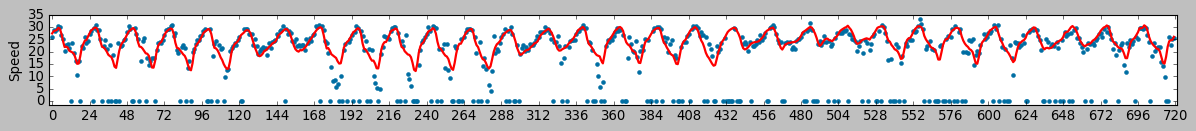

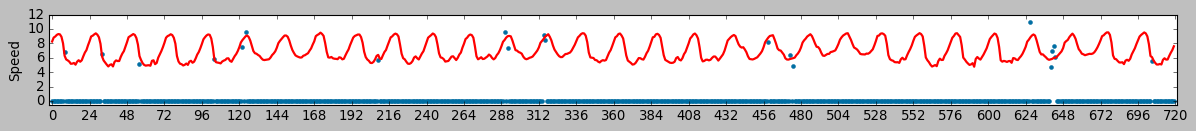

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

for loc in [2, 3]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.04, 0.18, 0.94, 0.75])
    plt.plot(sparse_mat[loc, :], '.', markersize = 7, color = "#006ea3")
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 24 * 30 + 1, 24))
    plt.xlim([-2, 721])
    if loc == 2:
        plt.ylim([-1.5, 35])
    elif loc == 3:
        plt.ylim(-0.5, 12)
    plt.ylabel('Speed')
    plt.show()
    fig.savefig("../images/london_movement_speed_impute{}.pdf".format(loc + 1))

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>